# 1. 引言

不同职业类型造成的心理压力也有程度上的不同，高强度竞争、容错率低、项目周期紧的职业可能更容易引发心理疾病。

本文尝试用机器学习的方法构建预测模型，探索职业类型与心理疾病之间的相关性，并比较K-Means、决策树、随机森林、SVM等几种预测模型的结果。

在这篇研究里我想解答以下两个问题：

1.职业类型是否与心理疾病相关？

2.职业类型对心理疾病的影响如何量化？

# 2. 数据来源与变量选取

本文所使用的数据为英国劳动力调查（Labor Force Survey, 以下简称LFS）2017年第二季度数据，可在UK Data Service公开下载（网址点此）。

选择这个数据集的原因是LFS的调查数据非常全面，且附有详尽的说明文档。国内的劳动力调查做得最好的是中山大学的CLDS，但还没有办法支撑这篇分析。

LFS调查分两大板块，第一大板块为基础问题，包括个人基本信息、家庭结构、家人状况等，第二大板块则分为教育、健康、经济活动等几个主题。其中健康类问题下的“HEALTH”字段记录了被采访者的主要健康问题，我们就用它作为分类标签，标注样本是否具有心理疾病。

用于建模的预测变量则选用以下几个（变量的详细说明见末尾附录）：

1.个人属性:

·SEX（性别）

·AGE（年龄）

2.职业属性:

·STAT(就业状态)

·INDE07M(所属行业)

·SC10MMJ(职位层级)

·TTUSHR(工作时长)

·SHFTYP(换班制度)

·GRSSWK(每周收入)

另外“LNGLST”（健康问题持续一年以上）、“ILODEFR”（是否在职）两个字段要用来筛选数据，在第一步分析中也予以保留。
接下来提取分析所需数据集。 

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 导入数据
data_raw = pd.read_csv("UK_LabourSurvey_2017Q2.csv", low_memory = False)
data_raw.head()

ACTHR  ACTHR2  ACTPOT  ACTUOT  ACTWKDY1  ACTWKDY2  ACTWKDY3  ACTWKDY4  \
0   -9.0    -9.0    -9.0    -9.0        -9        -9        -9        -9   
1   -9.0    -9.0    -9.0    -9.0        -9        -9        -9        -9   
2   -9.0    -9.0    -9.0    -9.0        -9        -9        -9        -9   
3   -9.0    -9.0    -9.0    -9.0        -9        -9        -9        -9   
4   -9.0    -9.0    -9.0    -9.0         1         2         3         4   

   ACTWKDY5  ACTWKDY6  ...  YERQAL2  YERQAL3  YLESS6  YMORE  YPAYL  YPAYM  \
0        -9        -9  ...       -9       -9      -9     -9     -9     -9   
1        -9        -9  ...       22       -9      -9     -9     -9     -9   
2        -9        -9  ...       21       -9      -9     -9     -9     -9   
3        -9        -9  ...       -9       -9      -9     -9     -9     -9   
4         5        -9  ...       -9       -9      -9     -9     -9     -9   

   YPTJOB  YSTART  YTETJB  YVARY99  
0      -9      -9      -9       -9  
1      -9      -9      -9       -9  
2      -9      -9      -9       -9  
3      -9      -9      -9       -9  
4      -9      -9      -9       -9  

[5 rows x 807 columns]

In [3]:
# 提取所需字段
keys = ["HEALTH", "SEX", "AGE", "STAT", "INDE07M", "SC10MMJ", 
        "TTUSHR", "SHFTYP", "GRSSWK", "ILODEFR","LNGLST"]
data_sub = data_raw[keys]
data_sub.head()

HEALTH  SEX  AGE  STAT  INDE07M  SC10MMJ  TTUSHR  SHFTYP  GRSSWK  ILODEFR  \
0      17    2   71    -9       -9       -9      -9      -9      -9        3   
1       9    2   68     2       -9       -9      -9      -9      -9        3   
2       2    1   66    -9       -9       -9      -9      -9      -9        3   
3      -9    2   35     1       -9       -9      -9      -9      -9        3   
4      -9    1   36     1        8        2      48      -9      -9        1   

   LNGLST  
0       1  
1       1  
2       1  
3       2  
4       2

In [4]:
# 筛选数据（只保留健康问题持续一年以上且仍在职的人群）
data_sub = data_sub[data_sub.ILODEFR == 1]
data_sub = data_sub[data_sub.LNGLST == 1]
data_sub.describe()

HEALTH           SEX           AGE          STAT       INDE07M  \
count  11121.000000  11121.000000  11121.000000  11121.000000  11121.000000   
mean       8.826904      1.504811     46.970686      1.176693      6.218955   
std        5.169064      0.499999     13.381677      0.549836      2.208833   
min       -8.000000      1.000000     16.000000     -9.000000     -9.000000   
25%        3.000000      1.000000     37.000000      1.000000      5.000000   
50%        9.000000      2.000000     49.000000      1.000000      7.000000   
75%       12.000000      2.000000     57.000000      1.000000      8.000000   
max       17.000000      2.000000     91.000000      4.000000      9.000000   

            SC10MMJ        TTUSHR        SHFTYP        GRSSWK  ILODEFR  \
count  11121.000000  11121.000000  11121.000000  11121.000000  11121.0   
mean       4.500045     33.421365     -6.631778    117.348979      1.0   
std        2.652782     15.929565      5.621941    286.639675      0.0   
min       -9.000000     -9.000000     -9.000000     -9.000000      1.0   
25%        2.000000     24.000000     -9.000000     -9.000000      1.0   
50%        4.000000     37.000000     -9.000000     -9.000000      1.0   
75%        7.000000     42.000000     -9.000000     69.000000      1.0   
max        9.000000     97.000000     10.000000   3769.000000      1.0   

        LNGLST  
count  11121.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

In [5]:
# 保存数据集
data_sub = data_sub.drop(columns=['ILODEFR', 'LNGLST'])
data_sub.to_csv("UK_LFS_2017Q2sub.csv")

# 3. 数据处理和清洗

数据处理分以下几步：

1.补全：补全空值和缺失数据

2.转换：转换数据类型

3.新增：按分析需要新增属性字段

4.修正：检查数据可信度，修正异常数据

## 3.1 处理空值

In [6]:
# 字段重命名（用更好懂的单词替代原始数据的缩写）
new_keys = ["Health","Sex","Age","EmplyStat","Industry","OccpGroup",
            "WkHours","Shift","Pay"]
data_cp = data_sub.copy()
data_cp.columns = new_keys
data_cp.head()

Health  Sex  Age  EmplyStat  Industry  OccpGroup  WkHours  Shift  Pay
16      17    2   28          1         8          2       38     10   -9
26      12    1   56          1         5          8       24     -9  190
29      10    1   42          1         3          5       24     -9   -9
39       2    1   50          1         3          8       -8      7   -9
42      -8    2   61          1         5          9       14     -9   -9

In [7]:
# 检查各列是否存在空值，LFS数据中用"-8"(不回答) and "-9"(不适用)表示
data_cp.describe()

Health           Sex           Age     EmplyStat      Industry  \
count  11121.000000  11121.000000  11121.000000  11121.000000  11121.000000   
mean       8.826904      1.504811     46.970686      1.176693      6.218955   
std        5.169064      0.499999     13.381677      0.549836      2.208833   
min       -8.000000      1.000000     16.000000     -9.000000     -9.000000   
25%        3.000000      1.000000     37.000000      1.000000      5.000000   
50%        9.000000      2.000000     49.000000      1.000000      7.000000   
75%       12.000000      2.000000     57.000000      1.000000      8.000000   
max       17.000000      2.000000     91.000000      4.000000      9.000000   

          OccpGroup       WkHours         Shift           Pay  
count  11121.000000  11121.000000  11121.000000  11121.000000  
mean       4.500045     33.421365     -6.631778    117.348979  
std        2.652782     15.929565      5.621941    286.639675  
min       -9.000000     -9.000000     -9.000000     -9.000000  
25%        2.000000     24.000000     -9.000000     -9.000000  
50%        4.000000     37.000000     -9.000000     -9.000000  
75%        7.000000     42.000000     -9.000000     69.000000  
max        9.000000     97.000000     10.000000   3769.000000

In [8]:
data_cp.EmplyStat.value_counts()

 1    9170
 2    1859
 4      66
 3      14
-9      12
Name: EmplyStat, dtype: int64

In [9]:
data_cp.Industry.value_counts()

 8    3595
 5    2090
 7    1735
 6     986
 3     931
 9     701
 4     699
 2     181
 1     142
-8      37
-9      24
Name: Industry, dtype: int64

In [10]:
data_cp.OccpGroup.value_counts()

 2    2152
 3    1463
 4    1261
 9    1195
 1    1138
 6    1131
 5    1072
 7     915
 8     765
-9      24
-8       5
Name: OccpGroup, dtype: int64

In [11]:
len(data_cp[(data_cp.WkHours == -9)|(data_cp.WkHours == -8)])

352

In [12]:
data_cp.Shift.value_counts()

-9     9363
 10     520
 3      403
 4      224
 8      164
 1      133
 7      108
 5       66
 6       63
 2       39
 9       31
-8        7
Name: Shift, dtype: int64

In [13]:
len(data_cp[(data_cp.Pay == -9)|(data_cp.Pay == -8)])

8248

不同列的空值数量差很多，所以要用不同方法处理。"EmplyStat", "Industry" ，"Health" 和 "OccpGroup" 等字段空值较少，可考虑直接删去。

In [14]:
# 删除空值所在行
# -8 means "no answer", -9 means"do not apply
data_cp = data_cp[data_cp.Health != -8]
data_cp = data_cp[(data_cp.EmplyStat != -8)&(data_cp.EmplyStat != -9)]
data_cp = data_cp[(data_cp.OccpGroup != -8)&(data_cp.OccpGroup != -9)]
data_cp = data_cp[(data_cp.Industry != -8)&(data_cp.Industry != -9)]
data_cp = data_cp[data_cp.Shift != -8]  # 这列保留 "-9" 值后续转换

data_cp.describe()

Health           Sex           Age     EmplyStat      Industry  \
count  10955.000000  10955.000000  10955.000000  10955.000000  10955.000000   
mean       8.966134      1.504610     46.989229      1.187403      6.301232   
std        4.946108      0.500002     13.368319      0.435785      1.929560   
min        1.000000      1.000000     16.000000      1.000000      1.000000   
25%        3.000000      1.000000     37.000000      1.000000      5.000000   
50%        9.000000      2.000000     49.000000      1.000000      7.000000   
75%       12.000000      2.000000     57.000000      1.000000      8.000000   
max       17.000000      2.000000     91.000000      4.000000      9.000000   

          OccpGroup       WkHours         Shift           Pay  
count  10955.000000  10955.000000  10955.000000  10955.000000  
mean       4.534733     33.552442     -6.631310    118.180192  
std        2.566400     15.750493      5.620539    287.936916  
min        1.000000     -8.000000     -9.000000     -9.000000  
25%        2.000000     24.000000     -9.000000     -9.000000  
50%        4.000000     37.000000     -9.000000     -9.000000  
75%        7.000000     42.000000     -9.000000     74.500000  
max        9.000000     97.000000     10.000000   3769.000000

“Pay”（收入）这一列空值比例达到74%，“WkHours”（工作时长）空值比例也有3%，考虑到这两个变量对最终模型预测影响较大，我们需要对其进行补全。

首先观察数据的分布。

<Axes: ylabel='Frequency'>

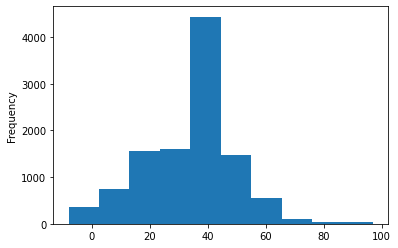

In [15]:
data_cp["WkHours"].plot.hist()

<Axes: ylabel='Frequency'>

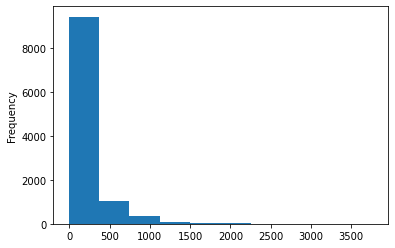

In [16]:
data_cp["Pay"].plot.hist()

两个字段的数据分布都符合常识经验，工作时长的分布接近正态分布，收入分布接近幂律分布。这意味着缺失的数据可能属于随机缺失（Missing At Random, MAR），所以我们可以用算法对其进行补全。

这里使用fancyimpute包的MICE函数（Multiple Imputation by Chained Equations）对缺失数据进行补全

In [1]:
pip install fancyimpute

  Using cached fancyimpute-0.7.0.tar.gz (25 kB)
  Using cached knnimpute-0.1.0.tar.gz (8.3 kB)
  Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl (8.3 MB)
  Using cached cvxpy-1.3.1-cp38-cp38-win_amd64.whl (889 kB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: packaging in d:\anaconda\lib\site-packages (from pytest->fancyimpute) (20.9)
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29891 sha256=6ff09f80a8ba406218a68c4e9b93cb7947e27b0e373f954c780e334caa153873
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\45\e1\7c\5f6e503d959df84af6d91e87ae288961a906f895d910f6533b
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11354 sha256=5d245dff35a937a6b7154e829988ccc961df59f9202a6e01c68bb53d18e5ede5
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\5f\e9\7a\9969b4e11eb626b45f12a46849b8c65aa718244a243583caf1
Successfully built fancyimpute knnimp

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [40]:
from fancyimpute import MICE

ImportError: cannot import name 'MICE' from 'fancyimpute' (D:\anaconda\lib\site-packages\fancyimpute\__init__.py)

In [39]:
# 将数据标识转换为空值
data_cp = data_cp.replace(-9, np.nan)
data_cp = data_cp.replace(-8, np.nan)
data_cp.head()

Health  Sex  Age  EmplyStat  Industry  OccpGroup  WkHours  Shift    Pay
16      17    2   28          1         8          2     38.0   10.0    NaN
26      12    1   56          1         5          8     24.0    NaN  190.0
29      10    1   42          1         3          5     24.0    NaN    NaN
39       2    1   50          1         3          8      NaN    7.0    NaN
52      17    1   63          1         7          9     12.0    NaN    NaN

In [41]:
data_cp.describe()

Health           Sex           Age     EmplyStat      Industry  \
count  10955.000000  10955.000000  10955.000000  10955.000000  10955.000000   
mean       8.966134      1.504610     46.989229      1.187403      6.301232   
std        4.946108      0.500002     13.368319      0.435785      1.929560   
min        1.000000      1.000000     16.000000      1.000000      1.000000   
25%        3.000000      1.000000     37.000000      1.000000      5.000000   
50%        9.000000      2.000000     49.000000      1.000000      7.000000   
75%       12.000000      2.000000     57.000000      1.000000      8.000000   
max       17.000000      2.000000     91.000000      4.000000      9.000000   

          OccpGroup       WkHours        Shift          Pay  
count  10955.000000  10643.000000  1727.000000  2842.000000  
mean       4.534733     34.770553     6.025478   481.051724  
std        2.566400     14.256469     3.194259   376.564781  
min        1.000000      0.000000     1.000000     6.000000  
25%        2.000000     25.000000     3.000000   231.000000  
50%        4.000000     37.000000     6.000000   392.000000  
75%        7.000000     42.000000    10.000000   615.000000  
max        9.000000     97.000000    10.000000  3769.000000

In [42]:
# 运行 MICE
data_imp = MICE(min_value = 0).complete(data_cp.as_matrix())

NameError: name 'MICE' is not defined

In [33]:
# 检查是否所有空值都补全了
data_imp = pd.DataFrame(data_imp)
assert data_imp.isnull().sum().sum() == 0, 'Not all NAs removed'

NameError: name 'data_imp' is not defined

In [43]:
data_imp.columns = data_cp.columns
data_imp.describe()

NameError: name 'data_imp' is not defined

In [44]:
# 检查补全后的数据分布
data_imp["WkHours"].plot.hist()

NameError: name 'data_imp' is not defined

In [35]:
data_imp["Pay"].plot.hist()

NameError: name 'data_imp' is not defined

## 3.2 转换数据类型

In [36]:
# 检查数据类型是否需要转换
data_imp.dtypes

NameError: name 'data_imp' is not defined

In [38]:
# "Shift" 字段简化为“0/1”编码（是否换班制工作）
for i in range(len(data_imp.index)):
    if data_cp.iloc[i,data_imp.columns.get_loc('Shift')] == -9:
        data_cp.iat[i,data_imp.columns.get_loc('Shift')] = 0
    else:
        data_cp.iat[i,data_imp.columns.get_loc('Shift')] = 1

NameError: name 'data_imp' is not defined